In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines
from pathlib import Path
import fastq as fq
import tqdm
import re
import sys
import seaborn as sns
import pysam
import scipy.stats

In [3]:
sys.path.append("/nfs/users/nfs_r/rs42/rs42/git/hapfusion/src")
sys.path.append("/nfs/users/nfs_r/rs42/rs42/git/himut/src")

In [4]:
import hapfusion
import himut

# Which samples?

In [5]:
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

# Functions to load _hapfusion_ summary files

## Loading files using T2T as reference

In [6]:
t2t_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/03.T2T-CHM13")

def t2t_load_files(sample_id):
    data_path = t2t_hapfusion_output_path / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"chm13.{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
        header=None,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}



## Loading files using hg19 as reference

In [7]:
hg19_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/01.grch37")

def hg19_load_files(sample_id):
    data_path = hg19_hapfusion_output_path / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"hg19.{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
        header=None,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}



## Loading files using de-novo assembly as reference

In [8]:
denovo_hapfusion_output_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")

def denovo_load_files(sample_id):
    data_path = denovo_hapfusion_output_path / sample_id
    if not (data_path / f"{sample_id}.hapfusion.txt").exists():
        data_path = denovo_hapfusion_output_path / sample_id / sample_id

    reads_df = pd.read_csv(
        str(data_path / f"{sample_id}.hapfusion.txt"),
        comment="#",
        delim_whitespace=True,
    )

    log_df = pd.read_csv(
        str(data_path / "hapfusion.log"),
        delim_whitespace=True,
        index_col=0,
    )

    candidates_df = pd.read_csv(
        str(data_path / "hapfusion_candidates.txt"),
        delim_whitespace=True,
    )

    return {"reads": reads_df, "summary": log_df, "candidates": candidates_df}





In [9]:
F = denovo_load_files("PD50523b")

In [10]:
F["summary"]

,chr1_RagTag,chr2_RagTag,chr3_RagTag,chr4_RagTag,chr5_RagTag,chr6_RagTag,chr7_RagTag,chr8_RagTag,chr9_RagTag,chr10_RagTag,...,chr16_RagTag,chr17_RagTag,chr18_RagTag,chr19_RagTag,chr20_RagTag,chr21_RagTag,chr22_RagTag,chrX_RagTag,chrY_RagTag,total
ccs,277803,299310,251738,246879,229346,213169,196196,189668,147025,166608,...,98521,85252,106128,50554,75084,48788,51109,8445,9376,3437343
lq_ccs,19737,18207,14262,13673,13365,11925,11982,11333,11308,9976,...,12585,5340,7027,4104,4785,5307,7887,670,6192,238970
hq_ccs,258066,281103,237476,233206,215981,201244,184214,178335,135717,156632,...,85936,79912,99101,46450,70299,43481,43222,7775,3184,3198373
unphased_ccs,45152,50681,41361,37862,36231,35397,28498,31038,23266,25642,...,15190,13559,14873,8380,11033,7169,6380,454,948,538236
hap_consistent_ccs,202524,218783,186610,184981,170658,157482,147537,139768,106899,124125,...,66987,63136,79647,36171,56157,34257,34589,5927,2045,2522586
hap_inconsistent_ccs,10390,11639,9505,10363,9092,8365,8179,7529,5552,6865,...,3759,3217,4581,1899,3109,2055,2253,1394,191,137551
hap_denovo_phase_switch_mutation_ccs,9911,11301,9161,10287,8818,8094,7898,7416,5376,6653,...,3672,3091,4424,1814,2961,2102,2366,1885,237,134089
hap_recombination_candidate_ccs,1767,1826,1504,1651,1550,1328,1350,1227,893,1131,...,625,546,787,301,499,359,419,207,38,22551
ambiguous,278,307,222,293,314,239,257,233,147,208,...,117,105,169,44,94,82,105,51,18,4129
crossover,12,17,10,10,11,15,6,8,8,7,...,5,7,13,5,2,4,6,1,2,184


# Calculate expected # of crossovers

## Get read lengths and number (precalculated)

In [11]:
depth_means = {}
depth_stds = {}
read_numbers = {}

ccs_read_path = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/02.ccs/")

for sample_id in sample_ids:
    count_path = ccs_read_path / sample_id / (sample_id + ".ccs.filtered.fastqc")
    d = open(count_path).read().strip().split()
    read_numbers[sample_id] = int(d[1])
    depth_means[sample_id] = float(d[3])
    depth_stds[sample_id] = float(d[4])

## Calculate

In [12]:
def plot_obs_vs_exp(df):
    qs = scipy.stats.binom(n=df.n_reads, p=df.prob_crossover_read).ppf(np.array([0.25, 1-0.25])[:, np.newaxis])

    fig, ax = plt.subplots()
    ax.errorbar(        
        x = df.n_expected_mean,
        y = np.arange(len(df)),
        xerr = [df.n_expected_mean - qs[0], qs[1] - df.n_expected_mean],
        fmt='o',
    )

    ax.scatter(        
        df.n_observed,
        np.arange(len(df)),
        c = "C1",
    )

    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df.sample_id)
    ax.set_ylabel("Sample ID")
    ax.set_xlabel("# of crossover events")
    ax.set_xlim(0, 800)

    for i in range(len(df)):
        ax.axhline(y = i, lw=0.05, c="black")

    return ax 

In [13]:
num_events_mean = 27
num_events_low = 20
num_events_high = 36

genome_size = 3.1e9

### For T2T

In [14]:
res = []

for sample_id in sample_ids:
    try:
        total_series = t2t_load_files(sample_id)["summary"]["total"]
        n_reads = total_series.loc["ccs"]
        n_obs = total_series.loc["crossover"]
        depth_mean = depth_means[sample_id]
        prob = (num_events_mean * depth_mean / genome_size)

        res.append([
            sample_id,
            n_obs,
            n_reads * prob,
            n_reads, 
            prob,
            scipy.stats.binom.logcdf(k=n_obs, n=n_reads, p=prob),
            scipy.stats.binom.logsf(k=n_obs, n=n_reads, p=prob),
        ])
    except:
        pass

t2t_exp_df = pd.DataFrame(res, columns=["sample_id", "n_observed", "n_expected_mean", "n_reads", "prob_crossover_read", "logcdf", "logsf"])

Text(0.5, 1.0, 'T2T reference')

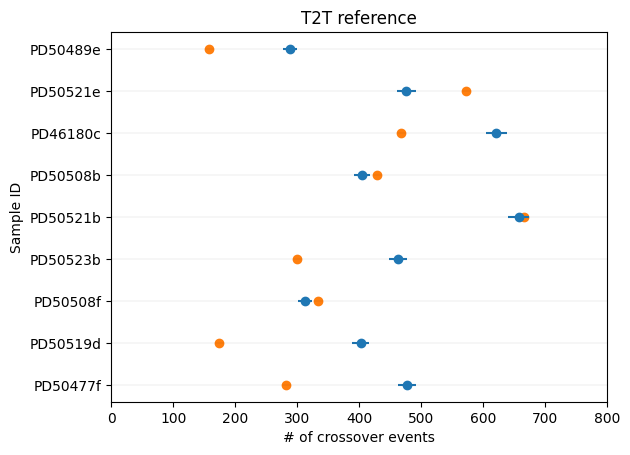

In [15]:
plot_obs_vs_exp(t2t_exp_df).set_title("T2T reference")

### For hg19

In [16]:
res = []

for sample_id in sample_ids:
    try:
        total_series = hg19_load_files(sample_id)["summary"]["total"]
        n_reads = total_series.loc["ccs"]
        n_obs = total_series.loc["crossover"]
        depth_mean = depth_means[sample_id]
        prob = (num_events_mean * depth_mean / genome_size)

        res.append([
            sample_id,
            n_obs,
            n_reads * prob,
            n_reads, 
            prob,
            scipy.stats.binom.logcdf(k=n_obs, n=n_reads, p=prob),
            scipy.stats.binom.logsf(k=n_obs, n=n_reads, p=prob),
        ])
    except:
        pass

hg19_exp_df = pd.DataFrame(res, columns=["sample_id", "n_observed", "n_expected_mean", "n_reads", "prob_crossover_read", "logcdf", "logsf"])

Text(0.5, 1.0, 'hg19 reference')

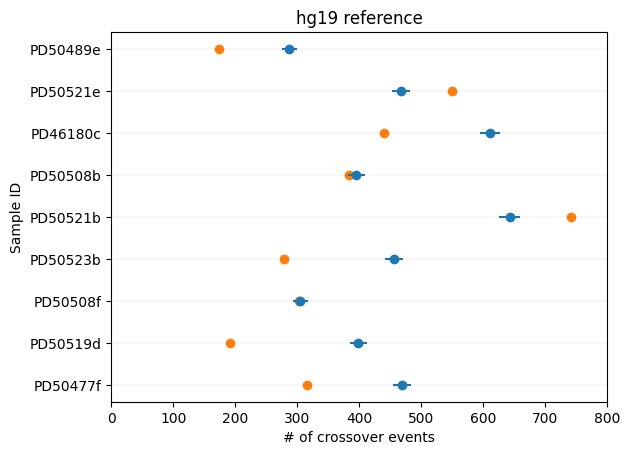

In [17]:
plot_obs_vs_exp(hg19_exp_df).set_title("hg19 reference")

### For denovo

In [18]:
res = []

for sample_id in sample_ids:
    try:
        total_series = denovo_load_files(sample_id)["summary"]["total"]
        n_reads = total_series.loc["ccs"]
        n_obs = total_series.loc["crossover"]
        depth_mean = depth_means[sample_id]
        prob = (num_events_mean * depth_mean / genome_size)

        res.append([
            sample_id,
            n_obs,
            n_reads * prob,
            n_reads, 
            prob,
            scipy.stats.binom.logcdf(k=n_obs, n=n_reads, p=prob),
            scipy.stats.binom.logsf(k=n_obs, n=n_reads, p=prob),
        ])
    except:
        pass

denovo_exp_df = pd.DataFrame(res, columns=["sample_id", "n_observed", "n_expected_mean", "n_reads", "prob_crossover_read", "logcdf", "logsf"])

Text(0.5, 1.0, 'hifiasm reference')

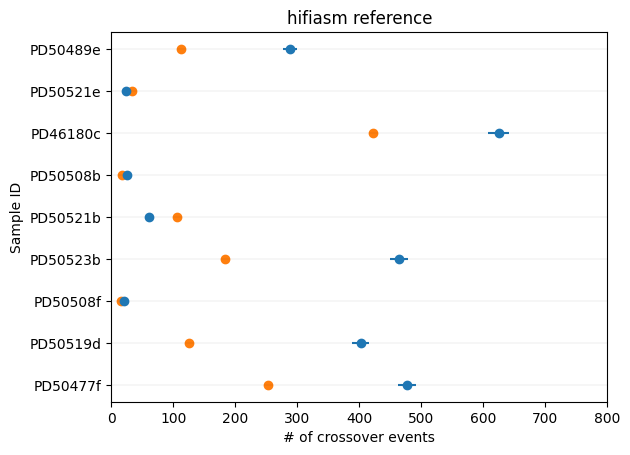

In [19]:
plot_obs_vs_exp(denovo_exp_df).set_title("hifiasm reference")

# Crossovers on sex chromosomes

In [20]:
res = []

for sample_id in sample_ids:
    row = []
    row.append(sample_id)

    # T2T
    try:
        summary = t2t_load_files(sample_id)["summary"]
        row.append(int(summary["chrX"].loc["crossover"]))
        row.append(int(summary["chrY"].loc["crossover"]))
    except:
        row.extend([np.nan, np.nan])

    # hg19
    try:
        summary = hg19_load_files(sample_id)["summary"]
        row.append(int(summary["X"].loc["crossover"]))
        row.append(int(summary["Y"].loc["crossover"]))
    except:
        row.extend([np.nan, np.nan])

    # Denovo
    try:
        summary = denovo_load_files(sample_id)["summary"]
        row.append(int(summary["chrX_RagTag"].loc["crossover"]))
        row.append(int(summary["chrY_RagTag"].loc["crossover"]))
    except:
        row.extend([np.nan, np.nan])

    res.append(row)

sex_df = pd.DataFrame(res, columns=["sample_id", "t2t_X", "t2t_Y", "hg19_X", "hg19_Y", "denovo_X", "denovo_Y"])


In [21]:
sex_df

,sample_id,t2t_X,t2t_Y,hg19_X,hg19_Y,denovo_X,denovo_Y
0,PD50477f,1,0,0,0,5,3
1,PD50519d,0,0,0,0,0,2
2,PD50508f,3,1,9,0,1,1
3,PD50523b,0,2,0,0,1,2
4,PD50521b,0,4,5,13,3,13
5,PD50508b,4,1,4,1,0,0
6,PD46180c,0,0,1,1,0,6
7,PD50521e,0,1,1,12,0,5
8,PD50489e,0,0,2,0,0,3


# Count GCs

In [22]:
summary

,chr1_RagTag,chr2_RagTag,chr3_RagTag,chr4_RagTag,chr5_RagTag,chr6_RagTag,chr7_RagTag,chr8_RagTag,chr9_RagTag,chr10_RagTag,...,chr16_RagTag,chr17_RagTag,chr18_RagTag,chr19_RagTag,chr20_RagTag,chr21_RagTag,chr22_RagTag,chrX_RagTag,chrY_RagTag,total
ccs,244581,263575,226662,213264,209615,190160,167045,167980,131913,151586,...,75490,65582,94288,37535,67479,48154,45403,7346,6327,3011062
lq_ccs,18285,17346,14641,13628,13414,11965,11541,11354,11270,10449,...,7578,4762,6017,2924,4429,5968,6434,526,2413,220981
hq_ccs,226296,246229,212021,199636,196201,178195,155504,156626,120643,141137,...,67912,60820,88271,34611,63050,42186,38969,6820,3914,2790081
unphased_ccs,45224,50843,42144,39981,38988,35109,30790,30316,23066,26615,...,13263,11909,15853,6095,12342,7767,7106,354,623,547147
hap_consistent_ccs,174314,188442,163823,153850,151605,137844,120214,121515,94132,110059,...,52343,47017,69736,27372,48831,32899,30358,5648,2484,2158800
hap_inconsistent_ccs,6758,6944,6054,5805,5608,5242,4500,4795,3445,4463,...,2306,1894,2682,1144,1877,1520,1505,818,807,84134
hap_denovo_phase_switch_mutation_ccs,6313,6346,5515,5504,5063,4808,4037,4525,2988,4136,...,2233,1723,2436,1209,1783,1343,1707,1013,3666,81027
hap_recombination_candidate_ccs,1307,1354,1219,1188,1114,1048,883,898,743,899,...,379,371,544,272,347,387,337,169,472,17051
ambiguous,215,207,153,205,195,185,149,155,104,147,...,55,80,103,58,54,91,99,41,219,3059
crossover,10,7,14,7,6,5,3,5,6,2,...,2,7,6,0,3,3,3,0,3,112


In [23]:
res = []

for sample_id in sample_ids:
    row = []
    row.append(sample_id)

    # T2T
    try:
        summary = t2t_load_files(sample_id)["summary"]
        row.append(int(summary["total"].loc["simple_gene_conversion"]))
        row.append(int(summary["total"].loc["complex_gene_conversion"]))
    except:
        row.extend([np.nan, np.nan])

    # hg19
    try:
        summary = hg19_load_files(sample_id)["summary"]
        row.append(int(summary["total"].loc["simple_gene_conversion"]))
        row.append(int(summary["total"].loc["complex_gene_conversion"]))
    except:
        row.extend([np.nan, np.nan])

    # Denovo
    try:
        summary = denovo_load_files(sample_id)["summary"]
        row.append(int(summary["total"].loc["simple_gene_conversion"]))
        row.append(int(summary["total"].loc["complex_gene_conversion"]))
    except:
        row.extend([np.nan, np.nan])

    res.append(row)

gc_df = pd.DataFrame(res, columns=["sample_id", "t2t_GC_simple", "t2t_GC_complex", "hg19_GC_simple", "hg19_GC_complex", "denovo_GC_simple", "denovo_GC_complex"])


In [24]:
gc_df

,sample_id,t2t_GC_simple,t2t_GC_complex,hg19_GC_simple,hg19_GC_complex,denovo_GC_simple,denovo_GC_complex
0,PD50477f,1214,3945,1167,11243,1215,3874
1,PD50519d,938,3210,972,9342,970,2199
2,PD50508f,1181,6439,1129,10523,30,208
3,PD50523b,1392,3821,1365,10055,1414,2425
4,PD50521b,1313,13443,1375,22863,145,1991
5,PD50508b,1703,7221,1671,12175,75,367
6,PD46180c,1440,7794,1343,14646,1482,6345
7,PD50521e,1742,8328,1647,15935,71,426
8,PD50489e,793,1718,788,9552,835,1596


# A finer calculation of expected number of crossovers

In [25]:
genetic_map = pd.read_csv(
    "/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/04.genetic_maps/01.Bherer_etal_SexualDimorphismRecombination/Refined_EUR_genetic_map_b37/male_chr1.txt",
    delim_whitespace=True,
)

In [26]:
(genetic_map
    .assign(start_pos = np.concatenate([[0], genetic_map.pos.values[:-1]]))
    .assign(end_pos = genetic_map.pos.values)
    [["chr", "start_pos", "end_pos"]]
)

,chr,start_pos,end_pos
0,chr1,0,777122
1,chr1,777122,918384
2,chr1,918384,1018704
3,chr1,1018704,1021415
4,chr1,1021415,1030565
...,...,...,...
66656,chr1,249122243,249143646
66657,chr1,249143646,249154567
66658,chr1,249154567,249158239
66659,chr1,249158239,249167690


(0.0, 300.0)

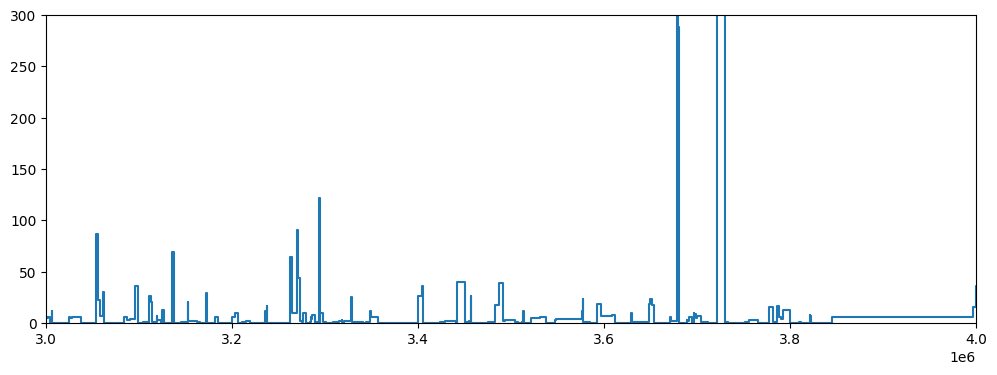

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.step(
    x = genetic_map.pos,
    y = genetic_map.rate,
)

ax.set_xlim(3e6, 3e6+1e6)
ax.set_ylim(0, 300)

### Make sure the lifted over BED file doesn't include overlapping segments

In [45]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]

for chrom in aut_chrom_names:
    bed_df = pd.read_csv(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/04.genetic_maps/02.T2T_lifted_Bherer_etal_SexualDimorphismRecombination/Refined_EUR_genetic_map_b37/male_{chrom}_output.bed",
        delim_whitespace=True,
        names=["chrom", "start_pos_0based", "end_pos_0based"],
    )

    D = bed_df.sort_values(by="start_pos_0based")
    print(chrom, np.all(D["start_pos_0based"].values[1:] >= D["end_pos_0based"].values[:-1]))

chr1 True
chr2 True
chr3 True
chr4 True
chr5 True
chr6 True
chr7 True
chr8 True
chr9 True
chr10 True
chr11 True
chr12 True
chr13 True
chr14 True
chr15 True
chr16 True
chr17 True
chr18 True
chr19 True
chr20 True
chr21 True
chr22 True


In [46]:
for chrom in aut_chrom_names:
    in_bed_df = pd.read_csv(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/04.genetic_maps/02.T2T_lifted_Bherer_etal_SexualDimorphismRecombination/Refined_EUR_genetic_map_b37/male_{chrom}_input.bed",
        delim_whitespace=True,
        names=["chrom", "start_pos_0based", "end_pos_0based"],
    )

    out_bed_df = pd.read_csv(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/01.data/07.references/04.genetic_maps/02.T2T_lifted_Bherer_etal_SexualDimorphismRecombination/Refined_EUR_genetic_map_b37/male_{chrom}_output.bed",
        delim_whitespace=True,
        names=["chrom", "start_pos_0based", "end_pos_0based"],
    )

    print(len(in_bed_df), len(out_bed_df))


66661 66469
67672 67464
54211 54063
51615 51425
47565 47436
48106 47958
45071 44909
40509 40377
37128 37016
40158 40030
37620 37537
39197 39076
29384 29307
25244 25190
23678 23620
24565 24491
21377 21293
23443 23383
14387 14301
20222 20166
11127 11090
12252 12200


In [48]:
918384-777123, 412844-270709

(141261, 142135)